In [23]:
import sys
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [24]:
import ms_deisotope
from ms_deisotope.test.common import datafile
from ms_deisotope.processor import ScanProcessor
from ms_deisotope.scoring import MSDeconVFitter

In [25]:
feature_id = 2

In [26]:
db_name = '/home/ubuntu/HeLa_20KInt/HeLa_20KInt-features-{}-{}.sqlite'.format(feature_id, feature_id)

In [27]:
# get all the feature matches with isolation windows
db_conn = sqlite3.connect(db_name)
feature_df = pd.read_sql_query("select * from feature_list where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [28]:
feature_df

,feature_id,charge_state,monoisotopic_mass,feature_centroid_scan,feature_centroid_rt,feature_centroid_mz,feature_start_rt,feature_end_rt,feature_scan_lower,feature_scan_upper,...,base_peak_scan_lower,base_peak_scan_upper,base_peak_centroid_rt,base_peak_std_dev_rt,base_peak_rt_lower,base_peak_rt_upper,base_peak_centroid_mz,base_peak_std_dev_mz,base_peak_mz_lower,base_peak_mz_upper
0,2,2,1247.602054,574.224714,1085.766969,625.127677,1075.17757,1097.628037,565,585,...,565,585,1085.746282,2.179954,1075.17757,1097.628037,624.809083,0.002324,624.778556,624.833736


In [29]:
feature_charge_state = int(feature_df.charge_state)

In [30]:
# get all the feature matches with isolation windows
db_conn = sqlite3.connect(db_name)
feature_isolation_matches_df = pd.read_sql_query("select distinct(precursor_id) from feature_isolation_matches where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [31]:
feature_isolation_matches_df

,precursor_id
0,26579
1,26603
2,26683
3,27234


In [32]:
precursor_id = 26579

In [33]:
# get all the ms2 peaks for this feature
db_conn = sqlite3.connect(db_name)
ms2_peaks_df = pd.read_sql_query("select * from ms2_peaks where feature_id={} and precursor={} order by peak_id ASC".format(feature_id, precursor_id), db_conn)
db_conn.close()

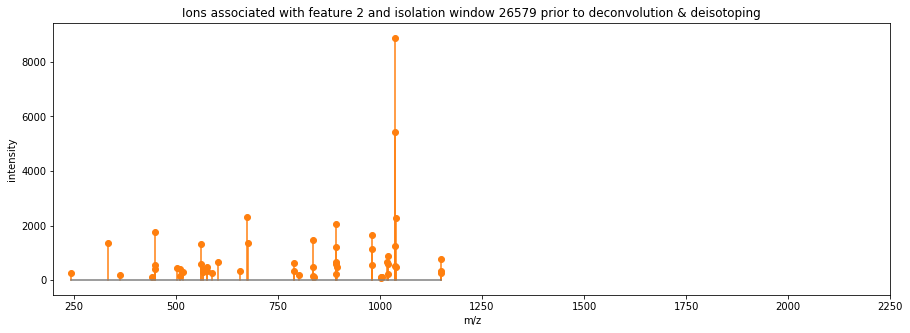

In [34]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(ms2_peaks_df.centroid_mz, ms2_peaks_df.intensity, linefmt="C1-", markerfmt="C1o", basefmt="C7-")
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.xlim(200,2250)
plt.margins(0.06)
plt.title('Ions associated with feature {} and isolation window {} prior to deconvolution & deisotoping'.format(feature_id, precursor_id))
plt.show()

Deconvolve and deisotope with ms_deisotope

In [35]:
mgf_name = '/home/ubuntu/HeLa_20KInt/mgf/feature-{}-precursor-{}.mgf'.format(feature_id,precursor_id)

In [36]:
reader = ms_deisotope.MSFileLoader(mgf_name)

In [37]:
scan = next(reader)

In [38]:
scan.pick_peaks().deconvolute(scorer=ms_deisotope.MSDeconVFitter(10), 
                              averagine=ms_deisotope.peptide,
                              charge_range=(1,feature_charge_state),
                              truncate_after=0.8)
deconvoluted_peaks = []
for peak in scan.deconvoluted_peak_set:
    deconvoluted_peaks.append((peak.neutral_mass, peak.intensity))

In [39]:
deconvoluted_peaks_df = pd.DataFrame(deconvoluted_peaks, columns=['neutral_mass','intensity'])

In [40]:
deconvoluted_peaks_df

,neutral_mass,intensity
0,332.177724,1363.000000
1,361.102724,184.000000
2,447.204724,2204.000000
3,447.211724,542.000000
4,502.255724,439.000000
5,508.716724,427.000000
6,510.169724,168.000000
7,517.717724,317.000000
8,560.287724,1923.000000
9,588.235724,266.000000


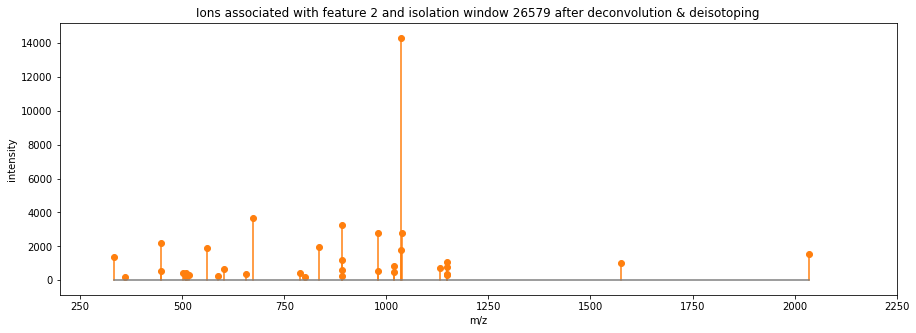

In [41]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(deconvoluted_peaks_df.neutral_mass, deconvoluted_peaks_df.intensity, linefmt="C1-", markerfmt="C1o", basefmt="C7-")
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.xlim(200,2250)
plt.margins(0.06)
plt.title('Ions associated with feature {} and isolation window {} after deconvolution & deisotoping'.format(feature_id, precursor_id))
plt.show()